<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:

import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import pickle
import xgboost
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import sklearn.metrics
from sklearn.preprocessing import LabelBinarizer


In [3]:
files_path = '/data/share/lab04data/'
train      = files_path + 'lab04_train.csv'
test       = files_path + 'lab04_test.csv'
target     = '/data/home/alexander.vertyagin/lab04.csv'

**То, что ты делаешь в функции mapping, можно проще сделать средствами sklearn - [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)**

**Но я думаю, делать тут именно это преобразование не совсем корректно, либо нужно подойти к этому аккуратно и посмотреть какие признаки что значат. OrdinalEncoder лучше подходит для порядковых категориальных признаков. Напрмер, образование: нет, неполное, среднее, высшее. В этом случае есть некоторое понимание, что чем лучше уровень образования, тем выше он стоит в шкале образования. Для дней недели, например, уже нельзя сопоставить такой порядок значимости дней. Более критично это было бы для линейных моделей, но, возможно, бустинг с этим лучше справляется. Я бы предложил использовать тут one-hot encoding:**

**[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)**

In [4]:
#оцифровка текстовых колонок частотой повторений 
def mapping(data, feature):
    featureMap = dict()
    count = 0
    for i in sorted(data[feature].unique().astype(str), reverse = True):
        featureMap[i] = count
        count = count + 1
    data_new = data.copy()   
    data_new[feature] = data[feature].astype(str).map(featureMap)
    return data_new

In [5]:
dfTrain = pd.read_csv(train, sep = ',')
dfTarget = dfTrain['TARGET'].fillna(0).copy()

**Заполнение нулями пропущенных значений - не всегда лучший способ. Полезно посмотреть распределение значений у каждого признака и на основе этого решить чем заполнить пропуски. Иногда подходят нули, иногда среднее значение, медиана или мода**

In [6]:
#заполнение нулями Nan значений
dfTrainF = dfTrain.fillna(0).copy()
#строковые поля
strFields = (  'CLNT_TRUST_RELATION', 'APP_MARITAL_STATUS', 'APP_KIND_OF_PROP_HABITATION', 'CLNT_JOB_POSITION_TYPE'
              ,'CLNT_JOB_POSITION', 'APP_KIND_OF_PROP_HABITATION', 'APP_DRIVING_LICENSE', 'APP_EDUCATION'
              ,'APP_TRAVEL_PASS', 'APP_CAR', 'APP_POSITION_TYPE', 'APP_EMP_TYPE', 'APP_COMP_TYPE', 'PACK')
for tabl in strFields:
   dfTrainF = mapping(dfTrainF, tabl)

In [7]:
dfTest = pd.read_csv(test, sep = ',')

In [8]:
delList = ['TARGET', 'ID']
dfTrainF = dfTrainF.drop(delList, axis = 1).copy()

**Не работал много с xgboost, видно что у тебя используется логистическая функция ошибки для задачи бинарной классификации. Но для меня не совсем понятно, почему ты выбрал XGBRegressor :) Судя по названию, он нужен для решения задач регрессии, а не классификации. Для задач классификации есть XGBClassifier. Возможно, разницы нет, но лучше уточнить**

In [9]:
#обучени Boosting model
X_train, X_test, y_train, y_test = train_test_split(
    dfTrainF,
    dfTarget,
    test_size    = 0.5,
    random_state = 50)

model = xgboost.XGBRegressor(n_estimators = 300, nthread= -1, max_depth = 3, objective = 'binary:logistic')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
#проверка roc_auc
testPred = model.predict(X_test)
print(roc_auc_score(y_test, testPred))

0.8440555478872962


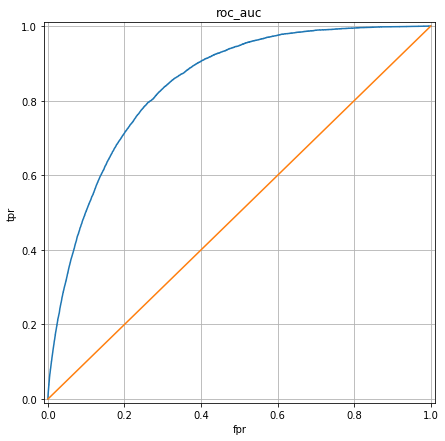

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
pyplot.figure(figsize = (7, 7) )
pyplot.plot(fpr, tpr)
pyplot.plot([0, 1], [0, 1])
pyplot.ylabel('tpr')
pyplot.xlabel('fpr')
pyplot.title('roc_auc')
pyplot.xlim((-0.01, 1.01))
pyplot.ylim((-0.01, 1.01))
pyplot.grid(True)

**Ты сначала разделил изначальную выборку на train и test, обучил на train и убедился, что модель показывает хорошее качество на test. Перед тем как делать прогноз для dfTest, можно было обучить модель с теми же параметрами на всей изначальной выборке, а не только на train. Могло бы получиться качество прогноза на dfTest несколько лучше :)**

In [11]:
# прогоняем проверочную выборку
dfTestF = dfTest.fillna(0).copy()
dfTestID = dfTestF['ID']
for tabl in strFields:
   dfTestF = mapping(dfTestF, tabl)
delList = ['ID']
dfTestF = dfTestF.drop(delList, axis = 1).copy()

In [12]:
testPredRes = model.predict(dfTestF)

In [13]:
df_out           = pd.DataFrame()
df_out['id']     = dfTestID
df_out['target'] = testPredRes

In [128]:
#сохраняем результат в csv файл
df_out.to_csv(target, sep='\t', index = False)